In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.tag_prediction.controllers.trainer_bilstm_crf import BiLSTMCRFTrainer
from torchlake.tag_prediction.models.bilstm_crf import (BiLSTMCRF,
                                                        LinearCRFLoss)
from torchtext.data import get_tokenizer
from torchlake.common.utils.text import build_vocab
from tqdm import tqdm

# setting


In [2]:
artifacts_path = Path("../../artifacts/bilstm-crf")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data/nerDataset")

In [3]:
batch_size = 128
CONTEXT = NlpContext(device="cuda:0")

In [4]:
tokenizer = get_tokenizer("basic_english")

In [5]:
DEVICE = torch.device(CONTEXT.device)

In [6]:
NUM_WORKERS = get_num_workers()

# data


In [7]:
# data = pd.read_csv(data_path.joinpath("ner_dataset.csv"), encoding="latin-1")

In [8]:
# data["Sentence #"] = data["Sentence #"].ffill()

In [9]:
# speedup groupby to save you hours to 10 seconds
# data = data.set_index("Sentence #")

In [10]:
# new_df = data.groupby(level=(0)).apply(
#     lambda row: [row["Word"].str.cat(sep=" "), row["Tag"].str.cat(sep=" ")]
# )

In [11]:
# new_df = pd.DataFrame(new_df.tolist(), columns=["Text", "Label"])

In [12]:
# new_df.to_csv(data_path.joinpath("processed.csv"), index=False)

# load text data


In [13]:
new_df = pd.read_csv(data_path.joinpath("processed.csv"))

In [14]:
# TODO: stratified so every label are present in train and test
train_data, test_data = train_test_split(new_df, test_size=1/5, random_state=32)

In [15]:
train_data

,Text,Label
2122,U Win Tin was arrested in 1989 and is serving ...,B-org I-org I-org O O O B-tim O O O O O O O O ...
1095,The last time the Vatican issued a vacant see ...,O O O O B-gpe O O O O O O O B-tim O O O B-per ...
46391,Witnesses say a top Palestinian bombmaker for ...,O O O O B-gpe O O O O B-geo I-geo O O O O B-ti...
22794,Pakistani police say a suicide bomber crashed ...,B-gpe O O O O O O O O O O O O O O O O O O O O ...
31861,The Defense Department is investigating the ac...,O B-org I-org O O O O O
...,...,...
24828,The militant Hezbollah movement fought a 34-da...,O O B-org O O O O O O B-geo O B-tim O O O O O ...
20414,The rebels say they will continue until the mo...,O O O O O O O O O O O O O O O O O O O O O
9526,The Olympic torch will make two trips to the w...,O O O O O O O O O O O O O O O O O O O O B-tim ...
42539,There were no reports of injuries and no claim...,O O O O O O O O O O O O


In [16]:
vocab = build_vocab(
    train_data["Text"].str.lower().str.split(),
    context=CONTEXT,
)

In [17]:
label_vocab = build_vocab(
    train_data["Label"].str.lower().str.split(),
    context=CONTEXT,
)

In [18]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(label_vocab)

In [19]:
VOCAB_SIZE, NUM_CLASS

(9104, 21)

In [20]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [21]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [22]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = tokenizer(text)
        text = text_transform(text)
        text_placeholder.append(text)
        
        label = tokenizer(label)
        label = label_transform(label)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [23]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

In [24]:
for text, label in train_iter:
    # print(text[0], label[0])
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128, 256])


# model


In [25]:
EMBED_DIM = 300
HIDDEN_DIM = 256

In [26]:
model = BiLSTMCRF(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=2,
    context=CONTEXT,
).to(DEVICE)

In [27]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
BiLSTMCRF                                --
├─LSTMDiscriminator: 1-1                 --
│    └─Embedding: 2-1                    2,731,200
│    └─LSTM: 2-2                         2,719,744
│    └─LayerNorm: 2-3                    1,024
│    └─Linear: 2-4                       10,773
├─LinearCRF: 1-2                         441
Total params: 5,463,182
Trainable params: 5,463,182
Non-trainable params: 0

# training


In [28]:
EPOCHES = 10

In [29]:
trainer = BiLSTMCRFTrainer(EPOCHES, DEVICE)

In [30]:
criterion = LinearCRFLoss(CONTEXT)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [32]:
training_loss = trainer.run(
    train_iter,
    model,
    optimizer,
    criterion,
    scheduler,
)

  0%|          | 0/299 [00:00<?, ?it/s]

100%|██████████| 299/299 [00:21<00:00, 14.15it/s]


epoch 1 : 12.279418501965576


100%|██████████| 299/299 [00:19<00:00, 15.05it/s]


epoch 2 : 9.9376846205032


100%|██████████| 299/299 [00:19<00:00, 15.43it/s]


epoch 3 : 8.170835475060453


100%|██████████| 299/299 [00:19<00:00, 15.41it/s]


epoch 4 : 6.88186370409452


100%|██████████| 299/299 [00:19<00:00, 15.35it/s]


epoch 5 : 5.7802342714673305


100%|██████████| 299/299 [00:19<00:00, 15.40it/s]


epoch 6 : 4.825836230281205


100%|██████████| 299/299 [00:19<00:00, 15.37it/s]


epoch 7 : 4.163181013885549


100%|██████████| 299/299 [00:20<00:00, 14.90it/s]


epoch 8 : 3.6480209189513855


100%|██████████| 299/299 [00:19<00:00, 15.34it/s]


epoch 9 : 3.287215100881647


100%|██████████| 299/299 [00:19<00:00, 15.23it/s]

epoch 10 : 3.0245470087663784


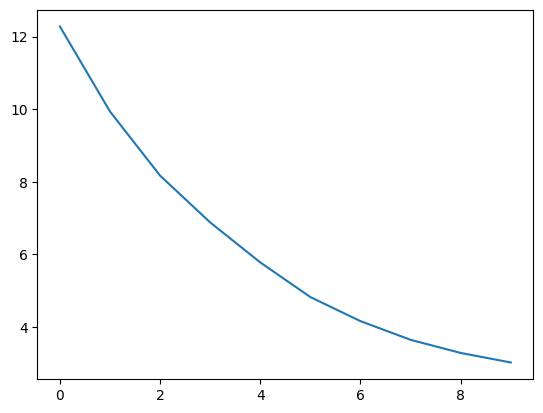

In [33]:
plt.plot(training_loss)

In [34]:
model_path = artifacts_path.joinpath("crf.pth")

In [35]:
torch.save(model.state_dict(), model_path)

In [36]:
get_file_size(model_path)

'20.84MiB'

In [37]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## baseline

In [44]:
baseline = LSTMDiscriminator(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=2,
    bidirectional=True,
    context=CONTEXT,
    sequence_output=True,
).to(DEVICE)

In [45]:
torchinfo.summary(baseline)

Layer (type:depth-idx)                   Param #
LSTMDiscriminator                        --
├─Embedding: 1-1                         2,731,200
├─LSTM: 1-2                              2,719,744
├─LayerNorm: 1-3                         1,024
├─Linear: 1-4                            10,773
Total params: 5,462,741
Trainable params: 5,462,741
Non-trainable params: 0

In [46]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, feature_last=True)

In [47]:
criterion = nn.CrossEntropyLoss(ignore_index=CONTEXT.padding_idx)
optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-3)

In [48]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=2,
    threshold=0.05,
    threshold_mode="rel",
)

In [49]:
training_loss = trainer.run(
    train_iter,
    baseline,
    optimizer,
    criterion,
    scheduler,
)

100%|██████████| 299/299 [00:18<00:00, 16.01it/s]


epoch 1 : 0.19110617948615033


100%|██████████| 299/299 [00:18<00:00, 16.13it/s]


epoch 2 : 0.1007926145375373


100%|██████████| 299/299 [00:17<00:00, 17.04it/s]


epoch 3 : 0.07531792180843178


100%|██████████| 299/299 [00:18<00:00, 16.34it/s]


epoch 4 : 0.05815438861432283


100%|██████████| 299/299 [00:18<00:00, 16.26it/s]


epoch 5 : 0.04380477744350864


100%|██████████| 299/299 [00:18<00:00, 16.59it/s]


epoch 6 : 0.03245909454730841


100%|██████████| 299/299 [00:17<00:00, 16.63it/s]


epoch 7 : 0.023066311401866352


100%|██████████| 299/299 [00:17<00:00, 16.64it/s]


epoch 8 : 0.01709391265472142


100%|██████████| 299/299 [00:18<00:00, 16.56it/s]


epoch 9 : 0.013104419069782049


100%|██████████| 299/299 [00:17<00:00, 16.63it/s]

epoch 10 : 0.00920975228372874


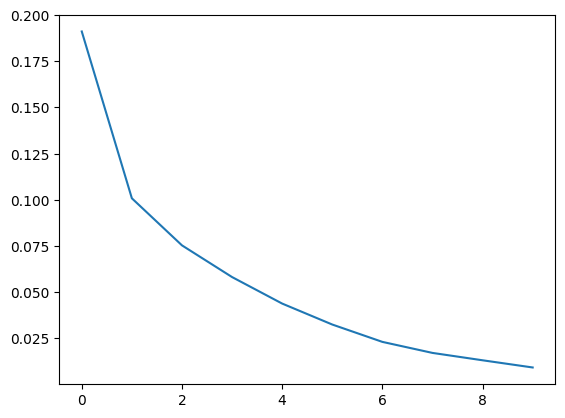

In [50]:
plt.plot(training_loss)

In [51]:
baseline_path = artifacts_path.joinpath("baseline.pth")

In [52]:
torch.save(baseline.state_dict(), baseline_path)

In [53]:
get_file_size(baseline_path)

'20.84MiB'

In [54]:
baseline.load_state_dict(torch.load(baseline_path))

<All keys matched successfully>

# prediction


In [38]:
model.eval()
with torch.no_grad():
    for i, (_, row) in enumerate(train_data.iterrows()):
        sentence, tag = row['Text'], row['Label']
        x = text_transform(tokenizer(sentence)).unsqueeze(0).to(DEVICE)
        tag_seq, score = model.forward(x, output_score=True)
        tag_seq = np.array(tag_seq.long()).flatten().tolist()
        decoded_seq = label_vocab.lookup_tokens(tag_seq)
        print("--------------sentence", i)
        print("score: ", score.item())
        print("pred : ", *[f"{d:<5}" for d in decoded_seq[1:-1]])
        print("label: ", *[f"{t:<5}" for t in tokenizer(tag)])
        print("text : ", sentence)
        print()
        if i > 10:
            break

--------------sentence 0
score:  -9899.2861328125
pred :  o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     o     

In [55]:
baseline.eval()
with torch.no_grad():
    for i, (_, row) in enumerate(train_data.iterrows()):
        sentence, tag = row['Text'], row['Label']
        x = text_transform(tokenizer(sentence)).unsqueeze(0).to(DEVICE)
        score = baseline(x).detach().cpu()
        tag_seq = score.argmax(-1).numpy().flatten().tolist()
        decoded_seq = label_vocab.lookup_tokens(tag_seq[:len(sentence.split())])
        print("--------------sentence", i)
        print("pred : ", *[f"{d:<5}" for d in decoded_seq])
        print("label: ", *[f"{t:<5}" for t in tokenizer(tag)])
        print("text : ", sentence)
        print()
        if i > 10:
            break

--------------sentence 0
pred :  <bos> b-org i-org i-org o     o     o     b-tim o     o     o     o     o     o     o     o     o     o    
label:  b-org i-org i-org o     o     o     b-tim o     o     o     o     o     o     o     o     o     o     o    
text :  U Win Tin was arrested in 1989 and is serving a 20-year sentence for writing anti-government propaganda .

--------------sentence 1
pred :  <bos> o     o     o     o     b-gpe o     o     o     o     o     o     o     b-tim o     o     o     b-per i-per i-per o    
label:  o     o     o     o     b-gpe o     o     o     o     o     o     o     b-tim o     o     o     b-per i-per i-per o     o    
text :  The last time the Vatican issued a vacant see stamp was in 1978 , when Pope John Paul I died .

--------------sentence 2
pred :  <bos> o     o     o     o     b-gpe o     o     o     o     b-geo i-geo o     o     o     o     b-tim o     o     b-gpe o     o     o     b-geo i-geo
label:  o     o     o     o     b-gpe o     o   

# Evaluation


## model

In [39]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [40]:
confusion_matrix = evaluator.run(test_iter, model.foot)

100%|██████████| 75/75 [00:07<00:00, 10.59it/s]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0 9592    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0 6259    0 3214   54    7    1    9    4   12    4    4   24
     0    0    0    0    0    0    0]
 [   0    0 3439    0 9592   43    3    0    7    1    5    2    9   15
     0    0    0    0    0    0    0]
 [   0    0  314    0 9590  541  194  355  174  310  346  129   72  145
     7    4    2    4    3    1    0]
 [   0    0    9    0 1647 3638   20  275   39   82   47   58   39    8
     1    3    0    0    0    0    0]
 [   0    0    3    0 1249   54 2354   19    8    6    7    0    5  133
     1    2    0    0    0    0    0]
 [   0    0    4    0 1182  415    9 1733   51  145   77   48    2    1
     4    1    0    0    1    0    0]
 [   0    0    3    0  400   17    2   16 1736  197   94    6   14    1
     0    0    0    0    0    0    0]
 [   0    

In [41]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 0.6525229357798165
<pad>     : 0.0
o         : 0.7866458863095727
b-geo     : 0.6201841118308898
b-tim     : 0.6128612340536319
b-org     : 0.47182139940103457
i-per     : 0.6983105390185036
b-per     : 0.6711786068009244
i-org     : 0.45139876718824085
b-gpe     : 0.758445332364693
i-geo     : 0.3911077618688772
i-tim     : 0.4613778705636743
b-art     : 0.0
b-eve     : 0.140625
i-art     : 0.025
i-eve     : 0.06976744186046512
b-nat     : 0.09523809523809523
i-gpe     : 0.22
i-nat     : 0.0


d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:104: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [42]:
per_class_acc[4:].mean()

0.380821296852859

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:123: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


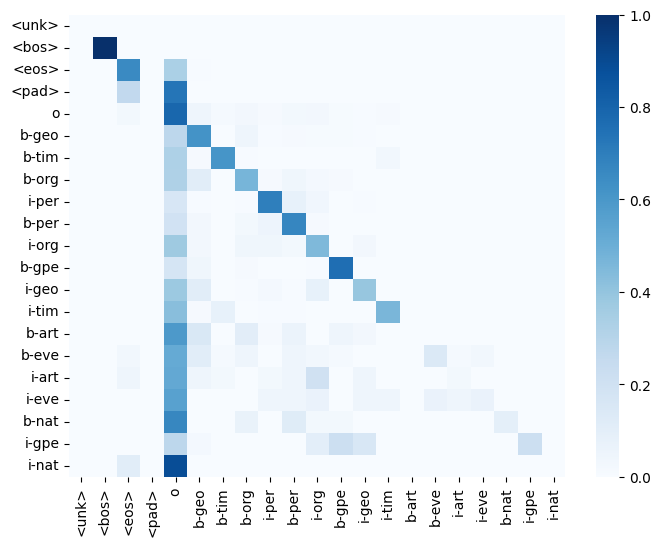

In [43]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

## baseline

In [56]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [57]:
confusion_matrix = evaluator.run(test_iter, baseline)

100%|██████████| 75/75 [00:05<00:00, 14.53it/s]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0 9592    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0 9165    0  393    5   19    0    0    0    0    0    5    5
     0    0    0    0    0    0    0]
 [   0    0 9592    0 1042    1    1    0    0    0    0    0    2    2
     0    0    0    0    0    0    0]
 [   0    0  498    0 9590  410  338  409  131  216  292   75  104  129
    11    5    8    6    7    3    2]
 [   0    0   20    0  605 4215   37  275   25  104   25   56   73    5
     2    1    0    0    2    1    0]
 [   0    0    3    0  457   41 3118    8    4    9    4    1    1   86
     1    0    0    0    0    0    0]
 [   0    0    4    0  660  541   16 2063   47  161   62   44    6    5
     5    1    0    2    0    0    0]
 [   0    0    4    0  196   28    0   44 1832  170  115    2   30    4
     0    0    3    0    0    1    0]
 [   0    

In [58]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 0.9554837364470392
<pad>     : 0.0
o         : 0.7838809874121301
b-geo     : 0.7739625413147264
b-tim     : 0.8352531476024645
b-org     : 0.5703621786010505
i-per     : 0.7542198435570193
b-per     : 0.7338104976141786
i-org     : 0.5212464589235127
b-gpe     : 0.8716896680343156
i-geo     : 0.6710424710424711
i-tim     : 0.6572327044025157
b-art     : 0.057971014492753624
b-eve     : 0.4090909090909091
i-art     : 0.07692307692307693
i-eve     : 0.1590909090909091
b-nat     : 0.34146341463414637
i-gpe     : 0.5625
i-nat     : 0.1111111111111111


d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:104: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [59]:
per_class_acc[4:].mean()

0.5229912314027817

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:123: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


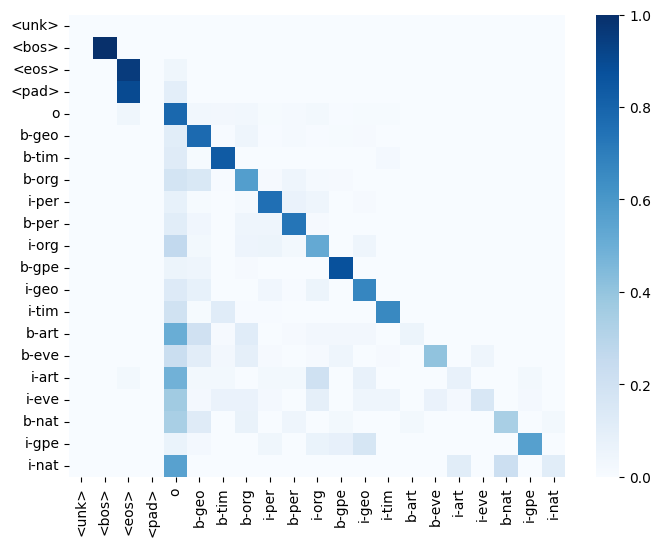

In [60]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

# Visualization


<Axes: title={'center': 'transition likelihood'}>

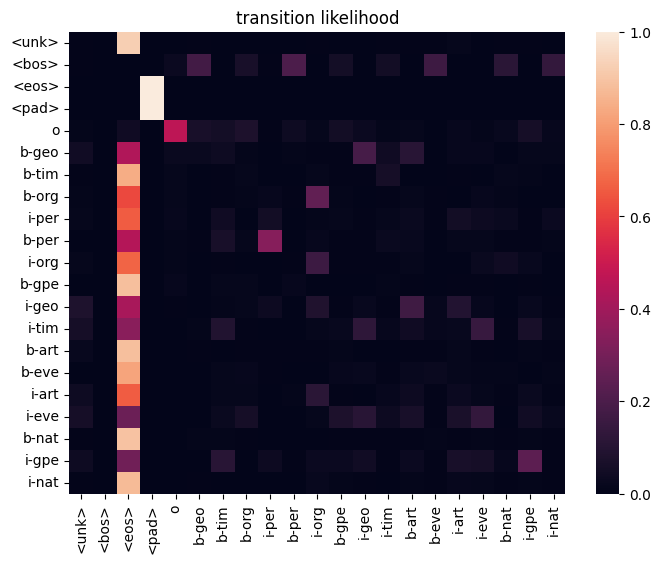

In [61]:
plt.figure(figsize=(8, 6))
plt.title('transition likelihood')
heatmap(
    model.head.transition
    .softmax(-1)
    # .div(-torch.inf)
    .clone()
    .detach()
    .cpu()
    .numpy(),
    xticklabels=label_vocab.get_itos(),
    yticklabels=label_vocab.get_itos(),
)